In [39]:
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from datetime import datetime

from transformers import pipeline
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments, TrainerCallback, EarlyStoppingCallback
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
torch.cuda.is_available()

True

## Качаем датасетик

In [4]:
!git clone https://huggingface.co/datasets/Daksh0505/IMDB-Reviews

Cloning into 'IMDB-Reviews'...


In [3]:
dataset_dict = []
dataset_dir = "IMDB-Reviews"

for filename in os.listdir(dataset_dir):
    if ".json" not in filename: continue

    filepath = os.path.join(dataset_dir, filename)
    with open(filepath, 'r', encoding="utf-8") as f:
        data = json.loads(f.read())

    for review in data["reviews"]:
        dataset_row = {
            "movie_id": data["movie_id"],
            "text": f"{review['title']}\n{review['review']}",
            "rating": review["rating"]
        }
        dataset_dict.append(dataset_row)

dataset_df = pd.DataFrame(dataset_dict)
dataset_df

,movie_id,text,rating
0,tt0058548,People Need To Lighten Up About This Movie\nTh...,4
1,tt0058548,Not NEARLY as bad as people make it out to be....,4
2,tt0058548,Can something this dumb really be harmless?\nM...,4
3,tt0058548,"Ludicrous, yet charming, Christmas-based nonse...",5
4,tt0058548,Harmless Christmas fun.\nI badly want to give ...,5
...,...,...,...
113533,tt9820556,Never ever pay money to watch this movie 😂\nI ...,[No Rating]
113534,tt9820556,I'm sorry. I couldn't do it!\nFact: the most e...,[No Rating]
113535,tt9820556,Promising Initial Story but so badly done\nAwf...,[No Rating]
113536,tt9820556,Is this a joke?\nI really can't figure this ou...,[No Rating]


In [4]:
dataset_df['rating'].value_counts()

rating
10             30737
1              27095
9               9221
8               7303
2               7002
7               6191
3               5576
[No Rating]     5405
5               5276
6               5215
4               4517
Name: count, dtype: int64

In [5]:
dataset_df = dataset_df[~(dataset_df["rating"] == "[No Rating]")]
dataset_df["rating"] = dataset_df["rating"].astype(int)
dataset_df["rating"].value_counts()

C:\Users\slityagin\AppData\Local\Temp\ipykernel_30100\2053964428.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_df["rating"] = dataset_df["rating"].astype(int)


rating
10    30737
1     27095
9      9221
8      7303
2      7002
7      6191
3      5576
5      5276
6      5215
4      4517
Name: count, dtype: int64

## Извлекаем фичи из текстов

Получаем фичи из берты, делаем датасет для обучения MLP

In [7]:
class BERTFeatureExtractor:
    """Класс для извлечения фич из BERT"""
    def __init__(self, model_name='bert-base-uncased', device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.model.to(device)
        self.model.eval()

    def get_embeddings(self, texts, batch_size=16, max_length=512):
        """Извлекает эмбеддинги для списка текстов"""
        all_embeddings = []

        with torch.no_grad():
            for i in tqdm(range(0, len(texts), batch_size)):
                batch_texts = texts[i:i + batch_size]

                # Токенизация
                inputs = self.tokenizer(
                    batch_texts,
                    padding=True,
                    truncation=True,
                    max_length=max_length,
                    return_tensors="pt"
                ).to(self.device)

                # Получаем эмбеддинги от BERT
                outputs = self.model(**inputs)

                # Используем эмбеддинг [CLS] токена как представление всего текста
                # (можно также использовать mean pooling)
                cls_embeddings = outputs.last_hidden_state[:, 0, :]

                all_embeddings.append(cls_embeddings.cpu().numpy())

        return np.vstack(all_embeddings)

In [8]:
feature_extractor = BERTFeatureExtractor()
embeddings = feature_extractor.get_embeddings(list(dataset_df["text"]))

100%|██████████████████████████████████████████████████████████████████████████████| 6759/6759 [26:03<00:00,  4.32it/s]


In [10]:
class EmbeddingDataset(Dataset):
    """Датасет для уже извлеченных эмбеддингов"""
    def __init__(self, embeddings, labels):
        self.embeddings = torch.FloatTensor(embeddings)
        self.labels = torch.LongTensor(labels)
        
    def __len__(self):
        return len(self.embeddings)
    
    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

def create_balanced_dataloader(embeddings, labels, batch_size=32):
    """Создает DataLoader с балансировкой классов"""
    dataset = EmbeddingDataset(embeddings, labels)
    
    # Вычисляем веса для каждого класса
    class_counts = np.bincount(labels)
    class_weights = 1. / class_counts
    sample_weights = class_weights[labels]
    
    # Создаем сэмплер
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True  # Разрешаем повторную выборку для малых классов
    )
    
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        sampler=sampler,  # используем sampler вместо shuffle
        drop_last=True
    )
    
    return dataloader

In [12]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(list(dataset_df["rating"]))  # Преобразуем 1-10 в 0-9

In [19]:
X_train, X_val, y_train, y_val = train_test_split(
        embeddings,
        labels_encoded,
        test_size=0.2,
        random_state=42,
        stratify=labels_encoded,
        shuffle=True
    )

print(f"Обучающая выборка: {len(X_train)} примеров")
print(f"Валидационная выборка: {len(X_val)} примеров")

Обучающая выборка: 86506 примеров
Валидационная выборка: 21627 примеров


In [20]:
# Проверяем распределение классов
def check_distribution(labels, dataset_name):
    unique, counts = np.unique(labels, return_counts=True)
    percentages = (counts / len(labels)) * 100
    print(f"\n{dataset_name}:")
    for cls, count, percent in zip(unique, counts, percentages):
        print(f"  Класс {cls}: {count} примеров ({percent:.1f}%)")

check_distribution(y_train, "TRAIN распределение")
check_distribution(y_val, "VAL распределение")


TRAIN распределение:
  Класс 0: 21676 примеров (25.1%)
  Класс 1: 5601 примеров (6.5%)
  Класс 2: 4461 примеров (5.2%)
  Класс 3: 3614 примеров (4.2%)
  Класс 4: 4221 примеров (4.9%)
  Класс 5: 4172 примеров (4.8%)
  Класс 6: 4953 примеров (5.7%)
  Класс 7: 5842 примеров (6.8%)
  Класс 8: 7377 примеров (8.5%)
  Класс 9: 24589 примеров (28.4%)

VAL распределение:
  Класс 0: 5419 примеров (25.1%)
  Класс 1: 1401 примеров (6.5%)
  Класс 2: 1115 примеров (5.2%)
  Класс 3: 903 примеров (4.2%)
  Класс 4: 1055 примеров (4.9%)
  Класс 5: 1043 примеров (4.8%)
  Класс 6: 1238 примеров (5.7%)
  Класс 7: 1461 примеров (6.8%)
  Класс 8: 1844 примеров (8.5%)
  Класс 9: 6148 примеров (28.4%)


In [21]:
train_dataloader = create_balanced_dataloader(X_train, y_train)
val_dataloader = create_balanced_dataloader(X_val, y_val)

## Обучаем MLP для классификации

In [47]:
class BERTMLPClassifier(nn.Module):
    """MLP классификатор поверх BERT эмбеддингов"""
    def __init__(self, input_dim=768, hidden_dims=[512, 768, 512, 264], num_classes=10, dropout=0.3):
        super(BERTMLPClassifier, self).__init__()

        self.name = "BERT_Sentimal"
        layers = []
        prev_dim = input_dim

        # Динамически создаем скрытые слои
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim

        # Выходной слой
        layers.append(nn.Linear(prev_dim, num_classes))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [40]:
def train_fn(epoch_index, model, loss_fn, optimizer, metrics, train_loader, DEVICE="cuda"):
    running_loss = 0.
    metrics_values = {}
    for key in metrics.keys():
        metrics_values[key] = 0.
    
    for i, (inputs, labels) in tqdm(enumerate(train_loader)):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        model.eval()
        outputs = F.softmax(outputs, dim=1)
        with torch.no_grad():
            for key, metric_func in metrics.items():
                metrics_values[key] += metric_func(outputs,labels).item()
        model.train()
    
    avg_loss = running_loss / len(train_loader) # loss per batch
    for key, metric_func in metrics.items():
        metrics_values[key] /= len(train_loader)
    print(f"Train | epoch {epoch_index} loss={avg_loss}")
    print(f"Metrics:\n {metrics_values}")

    return avg_loss, metrics_values

def valid_fn(epoch_index, model, loss_fn, metrics, valid_loader, DEVICE="cuda"):
    running_loss = 0.0
    metrics_values = {}
    for key in metrics.keys():
        metrics_values[key] = 0.
        
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in tqdm(enumerate(valid_loader)):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()
            
            outputs = F.softmax(outputs, dim=1)
            for key, metric_func in metrics.items():
                metrics_values[key] += metric_func(outputs,labels).item()
    model.train()
            
    avg_loss = running_loss / (len(valid_loader))
    for key, metric_func in metrics.items():
        metrics_values[key] /= len(valid_loader)
    print(f"Valid | epoch {epoch_index} loss={avg_loss}")
    print(f"Metrics:\n {metrics_values}")
    
    return avg_loss, metrics_values

In [39]:
def accuracy_metric(y_pred, y_true):
    cl_pred = torch.argmax(y_pred, dim=1)
    cl_true = y_true
    
    correct = (cl_pred == cl_true).sum().float()
    total = cl_true.numel()
    
    return correct / total

def f1_metric(y_pred, y_true):
    cl_pred = torch.argmax(y_pred, dim=1)
    cl_true = y_true
    num_classes = y_pred.shape[1]
    
    f1_scores = []
    for cls in cl_pred.unique().cpu().to(int):
        tp = ((cl_pred == cls) & (cl_true == cls)).sum().float()
        fp = ((cl_pred == cls) & (cl_true != cls)).sum().float()
        fn = ((cl_pred != cls) & (cl_true == cls)).sum().float()

        precision = tp / (tp + fp + 1e-9)
        recall = tp / (tp + fn + 1e-9)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-9)
        f1_scores.append(f1)

    return torch.stack(f1_scores).mean()
    
def TF_matrix(model, data_loader, classes, DEVICE="cuda"):
    matrix = torch.zeros((len(classes),len(classes))).to(DEVICE)
    
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loader):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            true_class = labels
            predict_class = torch.argmax(outputs, axis=1)
            
            for idx in range(len(true_class)):
                matrix[true_class[idx],predict_class[idx]]+=1 
    model.train()
    print(matrix)

In [54]:
def train_model(model, epochs, train_loader, valid_loader, save_dir="sentimal_lab", DEVICE="cuda"):
    save_model_dir = os.path.join(save_dir,model.name)
    if not os.path.exists(save_model_dir):
        save_experiment_dir = os.path.join(save_model_dir,f"exp_{1:03}")
        os.makedirs(save_experiment_dir, exist_ok=True)
    else:
        experiments_count = len(os.listdir(save_model_dir))
        save_experiment_dir = os.path.join(save_model_dir,f"exp_{(experiments_count)+1:03}")
        os.makedirs(save_experiment_dir, exist_ok=True)
        
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    train_losses = []
    valid_losses = []
    best_vloss = 200.0

    metrics = {
        "F1": f1_metric,
        "Accuracy": accuracy_metric
    }

    train_metrics = {}
    valid_metrics = {}
    for key in metrics.keys():
        train_metrics[key] = []
        valid_metrics[key] = []
    
    for epoch in range(epochs):
        print('EPOCH {}:'.format(epoch + 1))
    
        avg_loss, metrics_value = train_fn(epoch + 1, model, loss_fn, optimizer, metrics, train_loader)
        train_losses.append(avg_loss)
        avg_vloss, metrics_vvalue = valid_fn(epoch+1, model, loss_fn, metrics, valid_loader)
        valid_losses.append(avg_vloss)

        for key in metrics.keys():
            train_metrics[key].append(metrics_value[key])
            valid_metrics[key].append(metrics_vvalue[key])
            
        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            model_path = '{}/model_{}_{}.pt'.format(save_experiment_dir,timestamp, epoch)
            print(f"Best model path: {model_path}")
            torch.save(model.state_dict(), model_path)
            
    epoch_nums = [i+1 for i in range(epoch+1)]
    plt.plot(epoch_nums,train_losses,label="train")
    plt.plot(epoch_nums,valid_losses,label="valid")
    plt.xlabel("epochs")
    plt.ylabel("avg_cross_entropy")
    plt.title(model.name)
    plt.legend()
    plt.show()

    for key in metrics.keys():
        plt.plot(epoch_nums,train_metrics[key],label="train")
        plt.plot(epoch_nums,valid_metrics[key],label="valid")
        plt.xlabel("epochs")
        plt.ylabel(key)
        plt.title(model.name)
        plt.legend()
        plt.show()

def predict_sentiment(texts, model, feature_extractor, label_encoder):
    """Предсказание для новых текстов"""
    model.eval()

    # Извлекаем эмбеддинги
    embeddings = feature_extractor.get_embeddings(texts)

    # Предсказание
    with torch.no_grad():
        outputs = model(torch.FloatTensor(embeddings))
        predictions = torch.argmax(outputs, dim=1).numpy()

    # Преобразуем обратно к шкале 1-10
    return label_encoder.inverse_transform(predictions) + 1  # +1 чтобы вернуться к 1-10


In [55]:
model = BERTMLPClassifier(
    input_dim=768,
    hidden_dims=[512, 256, 512, 256, 128],
    num_classes=10
    ).to("cuda" if torch.cuda.is_available() else "cpu")

EPOCH 1:


2703it [00:53, 50.07it/s]


Train | epoch 1 loss=1.906727681193491
Metrics:
 {'F1': 0.24332600826541562, 'Accuracy': 0.2634225860155383}


675it [00:07, 85.11it/s]


Valid | epoch 1 loss=1.826459336457429
Metrics:
 {'F1': 0.26332389088692487, 'Accuracy': 0.28300925925925924}
Best model path: sentimal_lab\BERT_Sentimal\exp_003/model_20251119_013846_0.pt
EPOCH 2:


2703it [00:53, 50.63it/s]


Train | epoch 2 loss=1.839590998433318
Metrics:
 {'F1': 0.2656256519230458, 'Accuracy': 0.2861750832408435}


675it [00:08, 76.20it/s]


Valid | epoch 2 loss=1.8007928597485579
Metrics:
 {'F1': 0.2599148143000073, 'Accuracy': 0.2824537037037037}
Best model path: sentimal_lab\BERT_Sentimal\exp_003/model_20251119_013949_1.pt
EPOCH 3:


2703it [00:53, 50.08it/s]


Train | epoch 3 loss=1.8169490522779097
Metrics:
 {'F1': 0.2723073720162968, 'Accuracy': 0.2917707177210507}


675it [00:08, 75.75it/s]


Valid | epoch 3 loss=1.7915848913899175
Metrics:
 {'F1': 0.2678395147235305, 'Accuracy': 0.2914814814814815}
Best model path: sentimal_lab\BERT_Sentimal\exp_003/model_20251119_014051_2.pt
EPOCH 4:


2703it [00:54, 50.04it/s]


Train | epoch 4 loss=1.7921935233459445
Metrics:
 {'F1': 0.2798459892420638, 'Accuracy': 0.301378098409175}


675it [00:08, 79.50it/s]


Valid | epoch 4 loss=1.7786721528017961
Metrics:
 {'F1': 0.27049536423550713, 'Accuracy': 0.29435185185185186}
Best model path: sentimal_lab\BERT_Sentimal\exp_003/model_20251119_014154_3.pt
EPOCH 5:


2703it [00:55, 49.11it/s]


Train | epoch 5 loss=1.7744022106356943
Metrics:
 {'F1': 0.2833889275954646, 'Accuracy': 0.30589853866074734}


675it [00:08, 78.46it/s]


Valid | epoch 5 loss=1.78389248141536
Metrics:
 {'F1': 0.26697948908364333, 'Accuracy': 0.2919907407407407}


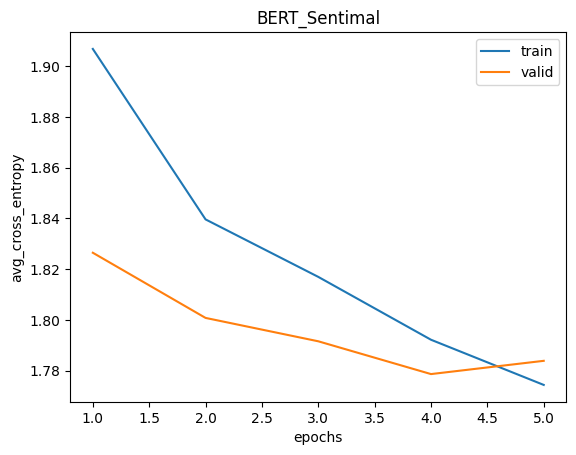

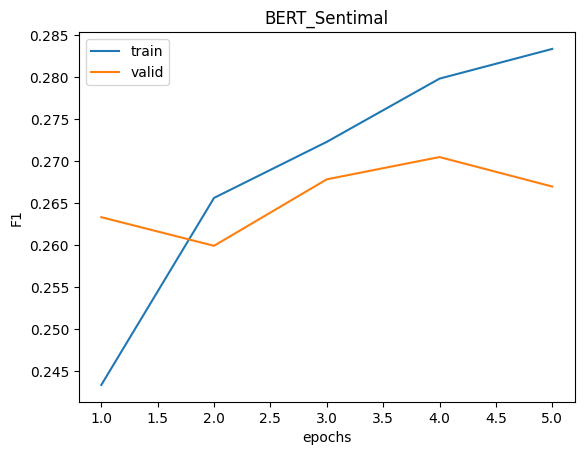

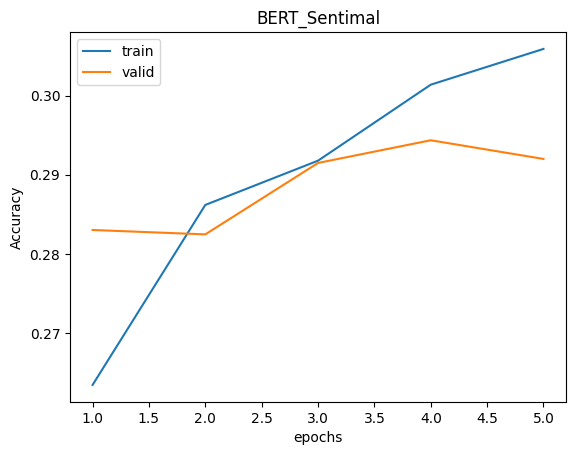

In [56]:
train_model(model, 5, train_dataloader, val_dataloader, save_dir="sentimal_lab")

## Пробуем другую схему

In [6]:
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [15]:
model_name = 'bert-base-uncased'
num_classes = 10

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_classes,
    problem_type="single_label_classification"  # или "regression" для регрессии
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(list(dataset_df["rating"]))  # Преобразуем 1-10 в 0-9

X_train_texts, X_val_texts, y_train, y_val = train_test_split(
        list(dataset_df["text"]),
        labels_encoded,
        test_size=0.2,
        random_state=42,
        stratify=labels_encoded,
        shuffle=True
    )

In [10]:
train_dataset = IMDBDataset(X_train_texts, y_train, tokenizer)
val_dataset = IMDBDataset(X_val_texts, y_val, tokenizer)

In [16]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Аргументы обучения с метриками
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,  # ← Количество эпох здесь
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",      # Оценка после каждой эпохи
    save_strategy="epoch",           # Сохранение после каждой эпохи
    load_best_model_at_end=True,
    metric_for_best_model="accuracy", # Какая метрика для выбора лучшей модели
    greater_is_better=True,          # Больше значение = лучше
    report_to=None,                  # Отключаем wandb/tensorboard если не нужно
    save_total_limit=2,              # Максимум 2 сохраненных модели
    no_cuda=False,  # ← явно указываем использовать CUDA если доступна
    dataloader_pin_memory=True,  # ускоряет загрузку данных для GPU
)

class GPUMonitorCallback(TrainerCallback):
    def on_step_begin(self, args, state, control, **kwargs):
        if state.global_step % 100 == 0:  # каждые 100 шагов
            if torch.cuda.is_available():
                print(f"Шаг {state.global_step}: GPU память занято: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")

# Создаем тренер с метриками
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,  # ← Добавляем вычисление метрик
    callbacks=[GPUMonitorCallback()],
)

# Обучаем
trainer.train()

C:\Users\slityagin\AppData\Local\Temp\ipykernel_30100\2595697942.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Шаг 0: GPU память занято: 2.14 GB


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.116800,1.203797,0.576317,0.506338,0.551824,0.576317
2,1.094400,1.164941,0.581542,0.532657,0.557444,0.581542
3,0.970100,1.251820,0.567901,0.547463,0.553882,0.567901
4,0.658000,1.394853,0.556665,0.549295,0.545068,0.556665
5,0.529900,1.556359,0.554492,0.548958,0.544250,0.554492


Шаг 100: GPU память занято: 2.96 GB
Шаг 200: GPU память занято: 2.96 GB
Шаг 300: GPU память занято: 2.96 GB
Шаг 400: GPU память занято: 2.96 GB
Шаг 500: GPU память занято: 2.96 GB
Шаг 600: GPU память занято: 2.96 GB
Шаг 700: GPU память занято: 2.96 GB
Шаг 800: GPU память занято: 2.96 GB
Шаг 900: GPU память занято: 2.96 GB
Шаг 1000: GPU память занято: 2.96 GB
Шаг 1100: GPU память занято: 2.96 GB
Шаг 1200: GPU память занято: 2.96 GB
Шаг 1300: GPU память занято: 2.96 GB
Шаг 1400: GPU память занято: 2.96 GB
Шаг 1500: GPU память занято: 2.96 GB
Шаг 1600: GPU память занято: 2.96 GB
Шаг 1700: GPU память занято: 2.96 GB
Шаг 1800: GPU память занято: 2.96 GB
Шаг 1900: GPU память занято: 2.96 GB
Шаг 2000: GPU память занято: 2.96 GB
Шаг 2100: GPU память занято: 2.96 GB
Шаг 2200: GPU память занято: 2.96 GB
Шаг 2300: GPU память занято: 2.96 GB
Шаг 2400: GPU память занято: 2.96 GB
Шаг 2500: GPU память занято: 2.96 GB
Шаг 2600: GPU память занято: 2.96 GB
Шаг 2700: GPU память занято: 2.96 GB
Шаг 2800: 

TrainOutput(global_step=13520, training_loss=0.9284375469712816, metrics={'train_runtime': 11457.5757, 'train_samples_per_second': 37.751, 'train_steps_per_second': 1.18, 'total_flos': 5.690579956755456e+16, 'train_loss': 0.9284375469712816, 'epoch': 5.0})

In [21]:
classifier = pipeline(
    "text-classification",
    model="./results/checkpoint-5408",
    tokenizer="./results/checkpoint-5408",
    device=0 if torch.cuda.is_available() else -1,
    max_length=512,  # максимальную длину
    truncation=True   # включаем обрезку длинных текстов
)

Device set to use cuda:0


In [22]:
pred_labels = classifier(X_val_texts)

In [29]:
numeric_pred_labels = []
confidences = []
    
for pred in pred_labels:
    label_str = pred['label']
    label_num = int(label_str.replace('LABEL_', ''))
    numeric_pred_labels.append(label_num)
    confidences.append(pred['score'])

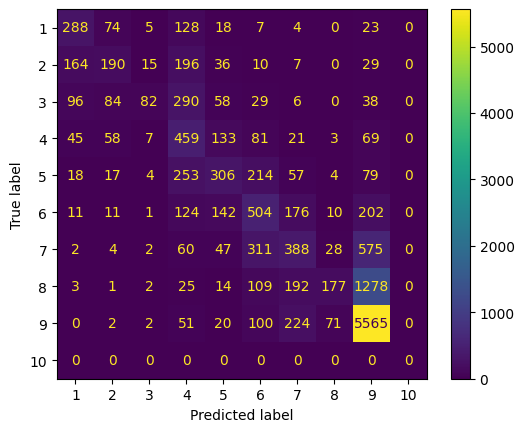

In [30]:
cm = confusion_matrix(y_val, numeric_pred_labels, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_encoder.classes_)
disp.plot()
plt.show()

## Пробуем по-друговски

In [36]:
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=1, 
    problem_type="regression" 
).to('cuda')

for param in model.bert.embeddings.parameters():
    param.requires_grad = False

for i in range(8):  # замораживаем первые 8 слоев
    for param in model.bert.encoder.layer[i].parameters():
        param.requires_grad = False

# Проверяем сколько параметров обучается
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Обучается {trainable_params}/{total_params} параметров ({trainable_params/total_params*100:.1f}%)")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Обучается 28942849/109483009 параметров (26.4%)


In [33]:
class RegressionDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = float(self.labels[idx])  # float для регрессии!
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

In [35]:
X_train_texts, X_val_texts, y_train, y_val = train_test_split(
        list(dataset_df["text"]),
        list(dataset_df["rating"]),
        test_size=0.2,
        random_state=42,
        stratify=labels_encoded,
        shuffle=True
    )

train_dataset = RegressionDataset(X_train_texts, y_train, tokenizer)
val_dataset = RegressionDataset(X_val_texts, y_val, tokenizer)

In [40]:
def compute_regression_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.flatten()
    
    mse = mean_squared_error(labels, predictions)
    mae = mean_absolute_error(labels, predictions)
    
    within_1 = np.sum(np.abs(predictions - labels) <= 1.0) / len(labels)
    
    return {
        'mse': mse,
        'rmse': np.sqrt(mse),
        'mae': mae,
        'within_1': within_1,
        'mean_pred': np.mean(predictions),
        'std_pred': np.std(predictions)
    }

training_args = TrainingArguments(
    output_dir='./regression_results',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=1e-5,
    weight_decay=0.1,             # увеличим регуляризацию
    warmup_steps=500,
    max_grad_norm=1.0,            # Gradient clipping
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="mae",
    greater_is_better=False,
    dataloader_pin_memory=False,
    report_to=None,
    no_cuda=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_regression_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],  # остановка после 2 эпох без улучшений
)

trainer.train()

C:\Users\slityagin\AppData\Local\Temp\ipykernel_30100\4079053944.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,Within 1,Mean Pred,Std Pred
1,3.028800,3.137471,3.137471,1.771291,1.088023,0.636057,5.865998,3.587127
2,2.798700,2.954668,2.954668,1.718915,1.052119,0.651963,5.913648,3.564858
3,2.633800,2.854091,2.854091,1.689406,1.039165,0.657142,5.865580,3.521964


TrainOutput(global_step=8112, training_loss=4.036188467954978, metrics={'train_runtime': 4187.1418, 'train_samples_per_second': 61.98, 'train_steps_per_second': 1.937, 'total_flos': 3.414072089394893e+16, 'train_loss': 4.036188467954978, 'epoch': 3.0})

In [44]:
regression = pipeline(
    "text-classification",
    model="./regression_results/checkpoint-8112",
    tokenizer="./regression_results/checkpoint-8112",
    device=0 if torch.cuda.is_available() else -1,
    max_length=512,  # максимальную длину
    truncation=True,   # включаем обрезку длинных текстов,
    function_to_apply="none"  # получаем сырые логиты
)

Device set to use cuda:0


In [47]:
pred_labels = regression(X_val_texts)

In [48]:
pred_labels[0]

{'label': 'LABEL_0', 'score': 8.993753433227539}

In [49]:
numeric_pred_labels = []
    
for pred in pred_labels:
    raw_value = pred['score']
        
    # Масштабируем/преобразуем если нужно
    # (зависит от того как вы обучали модель)
    final_rating = max(1, min(10, round(raw_value)))
    numeric_pred_labels.append(final_rating)

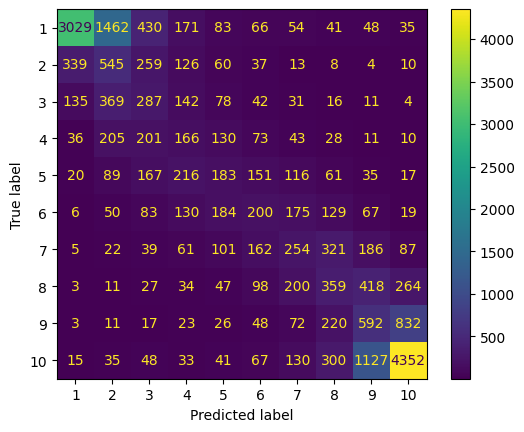

In [50]:
cm = confusion_matrix(y_val, numeric_pred_labels, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_encoder.classes_)
disp.plot()
plt.show()